In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

In [32]:
#*TC model for yield strength at room temperature
class TC_model:
    def __init__(self, x, f, k, r, r2, r3, delta, mu):
        self.x = x # atomic concentration
        self.f = f # packing factor
        self.k = k # bulk modulus
        self.r = r # TC-EARS atomic radii
        self.r2 = r2 # Var-EARS atomic radii
        self.r3 = r3 # Curtin's atomic radii
        self.delta = delta # change in composition
        self.mu = mu

    def lattice_param(self):
        matrix = self.sij()
        a =  1/self.f*np.dot(np.dot(self.x, matrix), self.x.T)
        return a

    def lattice_param_(self, x_):
        matrix = self.sij()
        a = np.dot(np.dot(x_, matrix), x_.T)
        return a

    def sij(self):
        k, r = self.k, self.r
        len_s = len(self.x[0])
        matrix = np.zeros((len_s, len_s))
        for i in range(len_s):
            for j in range(len_s):
                matrix[i][j] = ((4*(r[i]**2)*k[i]*self.x[0][i] + 4*(r[j]**2)*k[j]*self.x[0][j])/
                                    (2*r[i]*k[i]*self.x[0][i] + 2*r[j]*k[j]*self.x[0][j]))
        # print(matrix)
        return matrix

    def delta_(self, da_x):
        return np.dot(np.dot(self.x, da_x), self.x.T)

    def da_x_(self, i, j):
        dx = self.delta
        x = self.x
        x_ = x.copy()
        x_[0][i] -= dx
        x_[0][j] += dx
        da_x = (self.lattice_param()*self.f - self.lattice_param_(x_))/dx
        return da_x

    def ys_(self, s0):
        mu = self.mu
        a = self.lattice_param().flatten()[0]
        len_s = len(self.x[0])
        da_x = np.zeros((len_s, len_s))
        for i in range(len_s):
            for j in range(len_s):
                if i != j:
                    da_x[i][j] = abs(self.da_x_(i, j))**(4/3)
        delta = self.delta_(da_x)
        return s0 + 3.06*5*mu*((1*16/a)**(4/3))*delta

    #*deltaE_b
    def dEb(self):
        l_param = self.lattice_param().flatten()[0]
        x = self.x
        b = math.sqrt(2)/2*l_param
        print(f'b: {b}')
        atom_v3 = (2/0.74*self.r3)**3/4 #* atomic volume by radii from reference
        print(f'ave_atom by radii from closed packing model: {atom_v3}')
        atom_v2 = (self.r2*math.sqrt(2)*2)**3/4 #* atomic volume by radii from reference
        print(f'ave_atom by radii from closed packing model: {atom_v2}')
        atom_v = (2/0.74*self.r)**3/4 #* atomic volume by TC model
        print(f'ave_atom by TC model: {atom_v}')
        ave_atom_v = np.mean(atom_v) #*Mixture vol by average of atoms
        ave_atom_v3 = np.mean(atom_v3) #*Mixture vol by average of atoms
        ave_atom_v2  = np.mean(atom_v2)
        # print(f'ave_atom by linear average: {ave_atom_v}')
        # ave_atom_v = l_param**3/4 #* Mixture vol By lattice param calculated
        # print(f'ave_atom by lattice param: {ave_atom_v}')
        sum_x = 0
        for i in range(len(self.x[0])):
            sum_x += x[0][i]*((atom_v[i]-ave_atom_v)**2)/(b**6)

        sum_x2 = 0
        for i in range(len(self.x[0])):
            sum_x2 += x[0][i]*((atom_v2[i]-ave_atom_v2)**2)/(b**6)

        sum_x3 = 0
        for i in range(len(self.x[0])):
            sum_x3 += x[0][i]*((atom_v3[i]-ave_atom_v3)**2)/(b**6)

        poi_v = np.sum(x[0]*np.array([0.275, 0.293, 0.310]))
        poi_part = ((1+poi_v)/(1-poi_v))**(2/3)
        sum_part = sum_x**(1/3)
        sum_part2 = sum_x2**(1/3)
        sum_part3 = sum_x3**(1/3)
        delta_e = 0.274*(0.123**(1/3))*(b**3)*poi_part*5.7*sum_part*1e-36*self.mu*1e3
        delta_e2 = 0.274*(0.123**(1/3))*(b**3)*poi_part*5.7*sum_part2*1e-36*self.mu*1e3
        delta_e3 = 0.274*(0.123**(1/3))*(b**3)*poi_part*5.7*sum_part3*1e-36*self.mu*1e3
        return delta_e, delta_e2, delta_e3

    #*tao0 by Varvenne
    def tao0(self):
        k, r = self.k, self.r2
        len_s = len(self.x[0])
        matrix = np.zeros((len_s, len_s))
        for i in range(len_s):
            for j in range(len_s):
                matrix[i][j] = ((4*(r[i]**2)*k[i]*self.x[0][i] + 4*(r[j]**2)*k[j]*self.x[0][j])/
                                    (2*r[i]*k[i]*self.x[0][i] + 2*r[j]*k[j]*self.x[0][j]))
        l_param = 1/self.f*np.dot(np.dot(self.x, matrix), self.x.T).flatten()[0]

        x = self.x
        b = math.sqrt(2)/2*l_param
        atom_v1 = (self.r2*math.sqrt(2)*2)**3/4 #* atomic volume by radii from reference
        print(f'ave_atom by radii from closed packing model: {atom_v1}')
        atom_v2 = (2/0.74*self.r2)**3/4 #* atomic volume by TC model
        print(f'ave_atom by TC model: {atom_v2}')
        ave_atom_v = np.mean(atom_v2) #*Mixture vol by average of atoms
        print(f'ave_atom by linear average: {ave_atom_v}')
        # ave_atom_v = l_param**3/4 #* Mixture vol By lattice param calculated
        # print(f'ave_atom by lattice param: {ave_atom_v}')

        sum_x = 0
        for i in range(len(self.x[0])):
            sum_x += x[0][i]*((atom_v1[i]-ave_atom_v)**2)/(b**6)
        sum_part = sum_x**(2/3)

        poi_v = np.sum(x[0]*np.array([0.275, 0.293, 0.310]))
        poi_part = ((1+poi_v)/(1-poi_v))**(4/3)
        print(f'poission ration: {poi_v, poi_part}')

        return 0.051*(0.123**(-1/3))*poi_part*0.35*sum_part

2 ways to calc the atomic volume.

2 ways to calc the mixture volume.

In [45]:
#*Cr, Co, Ni
def mu_l(x):
    return 103.5*x[0][0] + 81*x[0][1] + 76*x[0][2]

x_4527 = np.array([[0.45, 0.275, 0.275]])
x_4525 = np.array([[0.45, 0.25, 0.3]])
x_4520 = np.array([[0.45, 0.20, 0.35]])
x_4515 = np.array([[0.45, 0.15, 0.4]])
x_3333 = np.array([[1/3, 1/3, 1/3]])
f = 0.74
k = np.array([160, 180, 180])/1000
r = np.array([129.25, 124.46, 123.28])
r2 = np.array([130.09, 124.30, 122.66])
r3 = np.array([122.7, 111.2, 109.4])

mu_4527 = mu_l(x_4527)
mu_4525 = mu_l(x_4525)
mu_4520 = mu_l(x_4520)
mu_4515 = mu_l(x_4515)
mu_3333 = mu_l(x_3333)

ys_tc_4527 = TC_model(x_4527, f, k, r, r2, r3, 0.001, mu_4527)
tao0_4527 = ys_tc_4527.ys_(60)[0][0]
ys_tc_4525 = TC_model(x_4525, f, k, r, r2, r3, 0.001, mu_4525)
tao0_4525 = ys_tc_4525.ys_(60)[0][0]
ys_tc_4520 = TC_model(x_4520, f, k, r, r2, r3, 0.001, mu_4520)
tao0_4520 = ys_tc_4520.ys_(60)[0][0]
ys_tc_4515 = TC_model(x_4515, f, k, r, r2, r3, 0.001, mu_4515)
tao0_4515 = ys_tc_4515.ys_(60)[0][0]
ys_tc_3333 = TC_model(x_3333, f, k, r, r2, r3, 0.001, mu_3333)
tao0_3333 = ys_tc_3333.ys_(60)[0][0]
tao0_4527, tao0_4525, tao0_4520, tao0_4515, tao0_3333

(349.61655416722493,
 357.47662674890915,
 371.3758105482599,
 381.1759328968827,
 311.2504473873934)

In [37]:
dE1_4527, _, _ = ys_tc_4527.dEb()
dE1_4525, _, _ = ys_tc_4525.dEb()
dE1_4520, _, _ = ys_tc_3333.dEb()
dE1_4515, _, _ = ys_tc_3333.dEb()
dE1_3333, _, _ = ys_tc_3333.dEb()
dE1_4527, dE1_4525, dE1_4520, dE1_4515, dE1_3333

b: 241.87938828734403
ave_atom by radii from closed packing model: [9117347.8520522  6786552.26738791 6462295.34282274]
ave_atom by radii from closed packing model: [12453938.88620162 10863965.43264568 10439600.27649136]
ave_atom by TC model: [10656792.06130436  9515338.14648688  9247252.44088208]
b: 241.79527111039326
ave_atom by radii from closed packing model: [9117347.8520522  6786552.26738791 6462295.34282274]
ave_atom by radii from closed packing model: [12453938.88620162 10863965.43264568 10439600.27649136]
ave_atom by TC model: [10656792.06130436  9515338.14648688  9247252.44088208]
b: 240.07097921475108
ave_atom by radii from closed packing model: [9117347.8520522  6786552.26738791 6462295.34282274]
ave_atom by radii from closed packing model: [12453938.88620162 10863965.43264568 10439600.27649136]
ave_atom by TC model: [10656792.06130436  9515338.14648688  9247252.44088208]
b: 240.07097921475108
ave_atom by radii from closed packing model: [9117347.8520522  6786552.26738791 6

(1.9006543258722484e-25,
 1.9067822758088653e-25,
 1.7429927242571985e-25,
 1.7429927242571985e-25,
 1.7429927242571985e-25)

In [347]:
ys_tc = TC_model(x, f, k, r, r2, r3, 0.001, mu)
tao0_var = ys_tc.tao0()
tao0_var

ave_atom by radii from closed packing model: [12453938.88620162 10863965.43264568 10439600.27649136]
ave_atom by TC model: [10865921.85916431  9478687.87139952  9108434.03695733]
ave_atom by linear average: 9817681.255840389
poission ration: (0.29266666666666663, 2.234343291326024)


417.2731013600596

In [20]:
ave_atom_list = np.array([10865921.85916431, 9478687.87139952, 9108434.03695733])
ave_atom_list - np.mean(ave_atom_list)

array([1048240.60332393, -338993.38444087, -709247.21888306])

In [27]:
#*Varvenne model for yield strength's temperature dependence
b = 1.380649e-23 # m2 -> pm2
def taoT(t0, dE, t):
    return t0*np.exp(-1/0.51*b*t/dE*math.log(1e7))

taoT(tao0_4527-60, dE1_4527, 293)
taoT(tao0_4525-60, dE1_4525, 293)
taoT(tao0_3333, dE1_3333, 293)
#* if removing the sigma_0, values are close to reference data.

311.2504473873934

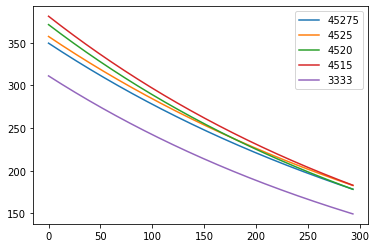

In [44]:
b = 1.380649e-23 # m2 -> pm2
def taoT(t0, dE, t):
    return t0*np.exp(-1/0.51*b*t/dE*math.log(1e7))

x_tc = np.linspace(0, 293, 10000)
tao_t_tc_4527 = taoT(tao0_4527, dE1_4527*1e6, x_tc)
tao_t_tc_4525 = taoT(tao0_4525, dE1_4525*1e6, x_tc)
tao_t_tc_4520 = taoT(tao0_4520, dE1_4520*1e6, x_tc)
tao_t_tc_4515 = taoT(tao0_4515, dE1_4515*1e6, x_tc)
tao_t_tc_3333 = taoT(tao0_3333, dE1_3333*1e6, x_tc)

plt.plot(x_tc, tao_t_tc_4527, label='45275')
plt.plot(x_tc, tao_t_tc_4525, label='4525')
plt.plot(x_tc, tao_t_tc_4520, label='4520')
plt.plot(x_tc, tao_t_tc_4515, label='4515')
plt.plot(x_tc, tao_t_tc_3333, label='3333')

legend = plt.legend()

# x_va = np.linspace(0, 293, 10000)
# tao_t_va = taoT(tao0_var, dE2, x_va)

# plt.plot(x_va, tao_t_va)